# Warmup: Estimating Discount Factors from Fixed Rate Bond Prices

Fixed rate bonds have a particularly simple pricing formula. Given unobserved discount factors (one at each cashflow date), the pricing formula is dot product. For the $i$-th bond having price $p_i$ and cashflow $c_{i,j}$ at cashflow date $j$ we have
$$ 
  p_i = \sum c_{i,j} z_j = \text{dot}(c,z).
$$
When there are multiple bonds we can write this as a matrix equation
$$
  Cz = p.
$$
Thus our first estimation problem is determining the unobserved vector $z$ given the price vector $p$ and cashflow matrix $C$.

We shouldn't be too surprised that this is typically an under-determined problem -- after all, each bond pays on multiple dates, and unless the dates line up in a perfect way, there will be more cashflow dates than bonds.

Therefore we need to impose some regularity conditions in order to uniquely determine $z$.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import quadprog as qp
import matplotlib.pylab as plt

In [2]:
bond_df = pd.read_csv('./Data/sample-bonds-1.csv')
bond_df.head()

,coupon,dirty price,maturity,pd-1,pd-2,pd-3,pd-4,pd-5,pd-6,pd-7,pd-8,pd-9
0,2.375,101.9825,5/15/2018,11/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.250,105.4372,12/15/2019,6/15/2019,12/15/2018,6/15/2018,12/15/2017,NaN,NaN,NaN,NaN,NaN
2,1.875,101.7911,1/15/2020,7/15/2019,1/15/2019,7/15/2018,1/15/2018,NaN,NaN,NaN,NaN,NaN
3,1.375,98.9160,3/31/2021,9/30/2020,3/31/2020,9/30/2019,3/31/2019,9/30/2018,3/31/2018,NaN,NaN,NaN
4,4.125,110.0907,10/15/2022,4/15/2022,10/15/2021,4/15/2021,10/15/2020,4/15/2020,10/15/2019,4/15/2019,10/15/2018,4/15/2018


In [3]:
T0 = dt.datetime(2017,11,7)
pd = [ [(dt.datetime.strptime(x,'%m/%d/%Y')-T0).days if type(x) is str else 0 for j,x in item.iteritems()] for i, item in bond_df.iloc[:,2:].iterrows()]

In [4]:
u_pd = np.unique(np.ravel(pd))
u_pd = u_pd[np.where(u_pd>0)]
n = len(bond_df)
m = len(u_pd)
print('%d bonds and %d cashflow dates' % (n,m) )

5 bonds and 29 cashflow dates


In [5]:
p = np.array(bond_df['dirty price'])
C = np.zeros( (n,m) )
for i in range(n):
    c = 0.5*bond_df.iloc[i,0]
    for k,x in enumerate(pd[i]):
        if x>0:
            j = np.where(u_pd==x)[0][0]
            C[i,j] = c if k > 0 else 100+c

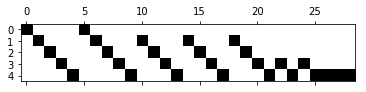

In [6]:
plt.spy(C);
plt.show();

## First attempt

First we solve using the psuedo-inverse.

In [7]:
z = np.linalg.pinv(C).dot(p)
print(z)
print('Error=%3.2g' % np.linalg.norm(C.dot(z)-p))

[ 0.01182621  0.01657304  0.00936324  0.00670605  0.02171796  1.00771791
  0.01657304  0.00936324  0.00670605  0.02171796  0.01657304  0.00936324
  0.00670605  0.02171796  0.01657304  0.00936324  0.00670605  0.02171796
  1.0364524   1.00810886  0.00670605  0.02171796  0.00670605  0.02171796
  0.98213122  0.02171796  0.02171796  0.02171796  1.07470972]
Error=6.2e-14


Not surprisingly the error is numerically zero. However, the solution does not meet our usual expectations about discount factors: they should be decreasing and between 0 and 1. (This assumes interest rates are non-negative, which in reality does not always hold.)

Let's convert this a minimization problem where we can apply contraints.
$$\begin{align}
  \tfrac {1}{2} \|Cz-p\|^2 &= {\tfrac {1}{2}} <Cz,Cz>^2 - <Cz,p> + {\tfrac {1}{2}} <p,p>^2 \\
             &= {\tfrac {1}{2}} z'C'Cz - p'Cz + {\tfrac {1}{2}} p'p
\end{align}$$

This can be solved numerically with a Quadratic Programming (QP) solver.

In [8]:
# Set up the problem with H = C'C and f - p'C
H = C.T.dot(C)
H1 = H + np.diag(1e-9*np.ones(len(C.T))) # make G positive definite
f = p.dot(C)

In [9]:
# Initial QP solution without contraints. It should be close to our pseudo-inverse soltuion
qp_res = qp.solve_qp(H1,f)
z = qp_res[0]
print(z)
print('Error=%3.2g' % np.linalg.norm(C.dot(z)-p))

[ 0.01182066  0.01661702  0.00934328  0.00668845  0.02181274  1.00771798
  0.01660358  0.00934042  0.00668947  0.02178905  0.01661831  0.00933326
  0.00669645  0.02180326  0.01661797  0.00933799  0.00669645  0.02179308
  1.03644977  1.00810977  0.00669633  0.02178544  0.00669633  0.02180292
  0.98213172  0.02177817  0.02179908  0.02178841  1.07469576]
Error=2.3e-11


Now add contraints
$$\begin{gather}
  z_j > z_{j+1} \\
  1 > z_j > 0
\end{gather}$$

In [10]:
# z_j - z_{j+1} > 0
A1 = np.diag(np.ones(m)) - np.diag(np.ones(m-1),1)
A1 = A1[:m-1,0:m]
b1 = np.zeros(m-1)

# -z > -1
A2 = -np.diag(np.ones(m))
b2 = -np.ones(m)

# z > 0
A3 = np.diag(np.ones(m))
b3 = np.zeros(m)

A = np.block([
    [A1],
    [A2],
    [A3]
])

b = np.block([b1,b2,b3])

In [11]:
qp_res = qp.solve_qp(H1,f,A.T,b)
z = qp_res[0]
print(z)
print('Error=%4.3g' % np.linalg.norm(C.dot(z)-p))

[ 0.99616606  0.99616606  0.99616606  0.99616606  0.99616606  0.99616606
  0.97482094  0.97482094  0.97482094  0.97482094  0.97482094  0.97482094
  0.97482094  0.97482094  0.97482094  0.97482094  0.97482094  0.97482094
  0.97482094  0.97204221  0.94276123  0.94276123  0.94276123  0.94276123
  0.94276123  0.90637887  0.90637887  0.90637887  0.90637887]
Error=1.41e-10


Now we have a nicely decreasing function with values that look like discount factors and a very good fit.

Before claiming success however, let's look at the implied zero rates $r(t)$, which are defined as
$$
   z_j = e^{-r(t_j)t_j}
$$

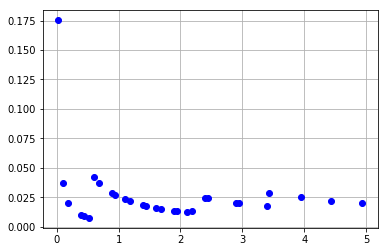

In [12]:
tj = u_pd/365.0
plt.plot(tj, -np.log(z)/tj,'bo');
plt.grid(True)
plt.show();

Now we observe this is not "smooth". Perhaps our solution is still not regular enough. To proceed we should treat $r(t_j)$ as state. This will lead us outside the realm where pricing is linear in terms of state.